In [3]:
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

plt.rc('text', usetex=True)

def generateScalarMesh(X, Y, f):
    Z = []
    for y in Y:
        for x in X:
            Z.append(f(np.array([x, y])))

    Z = np.array(Z).reshape((len(X), len(Y)))
    return Z

def generateVectorMesh(X, Y, f):
    U = []
    V = []
    for y in Y:
        for x in X:
            z = f(np.array([x, y]))
            U.append(z[0])
            V.append(z[1])
            
    U = np.array(U).reshape((len(X), len(Y)))
    V = np.array(V).reshape((len(X), len(Y)))
    return U, V

def marginedSupport(xs, marginPercent = 0.75, steps = 100):
    xmin = min(xs)
    xmax = max(xs)
    xrange_ = xmax - xmin
    xmargin = marginPercent * xrange_
    support = np.linspace(xmin - xmargin, xmax + xmargin, steps)
    return support

def contourPlot(fig, ax, X, Y, Z):
    cmap = plt.get_cmap('viridis')
    im = ax.contourf(X, Y, Z, cmap=cmap)
    fig.colorbar(im, ax=ax)
    
def streamPlot(fig, ax, trace, f):
    start = trace[0]
    end = trace[-1]
    
    xs = map(lambda x : x[0], trace)
    ys = map(lambda x : x[1], trace)

    X = marginedSupport(xs, 25)
    Y = marginedSupport(ys, 25)
    U, V = generateVectorMesh(X, Y, lambda x : -f(x))
    ax.streamplot(X, Y, U, V, color=U, linewidth=2, cmap=plt.cm.autumn)
        
def trajectoryPlot(fig, ax, trace, f):
    start = trace[0]
    end = trace[-1]
    
    xs = map(lambda x : x[0], trace)
    ys = map(lambda x : x[1], trace)

    X = marginedSupport(xs)
    Y = marginedSupport(ys)
    Z = generateScalarMesh(X, Y, lambda x : np.log(f(x)))

    contourPlot(fig, ax, X, Y, Z)
    
    ax.plot(xs, ys, c='r')
    ax.scatter(trace[0][0], trace[0][1], label="Start")
    ax.scatter(trace[-1][0], trace[-1][1], label="End")
    ax.legend()

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("log(Objective Function) Contour")

    print "Start: f(", trace[0], ") =", f(trace[0])
    print "End: f(", trace[-1], ") =", f(trace[-1])
    
def convergencePlot(ax, trace, f, dfd0):
    ax.plot(range(0, len(trace)), map(lambda x : f(x), trace), label=r'f(x,y)')
    ax.plot(range(0, len(trace)), map(lambda x : np.linalg.norm(dfd0(x)), trace), label=r'norm(\nabla f)')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("log(Function Value)")
    ax.set_title("Convergence")
    ax.set_yscale("log")
    ax.legend()

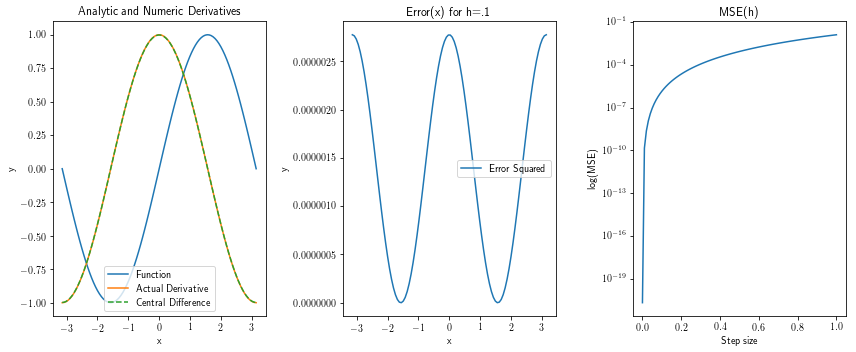

In [21]:
def centralDiffGrad(f, theta, step = 0.1):
    def centralDiff(x, i):
        x[i] += step
        a = f(theta)
        x[i] -= 2.0 * step
        b = f(theta)
        x[i] += step
        return (a - b) / (2.0 * step)

    assert theta.ndim <= 2

    result = np.zeros(theta.shape)
    if theta.ndim == 1:
        for r in xrange(len(theta)):
                result[r] = centralDiff(theta, r)
    else:
        (rows, cols) = theta.shape
        for r in xrange(0, rows):
            for c in xrange(0, cols):
                result[r, c] = centralDiff(theta, (r, c))
            
    return result

f = lambda x : np.sin(x)
fx = lambda x : np.cos(x)

XS = np.linspace(-np.pi, +np.pi, 100)
XSf = map(f, XS)
XSfx = map(fx, XS)
XScd = map(lambda x : centralDiffGrad(f, np.array([x]), 0.1), XS)

stepSizes = np.linspace(1e-6, 1e0, 100)
error = map(lambda step : np.average(map(lambda x : np.power(fx(x) - centralDiffGrad(f, np.array([x]), step), 2.0), XS)), stepSizes)

# Plot
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12, 5)
ax[0].plot(XS, XSf, label="Function")
ax[0].plot(XS, XSfx, label="Actual Derivative")
ax[0].plot(XS, XScd, label="Central Difference", linestyle="dashed")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Analytic and Numeric Derivatives")
ax[0].legend()

ax[1].plot(XS, map(lambda (x, y) : (x - y) ** 2, zip(XSfx, XScd)), label="Error Squared")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Error(x) for h=.1")
ax[1].legend()

ax[2].plot(stepSizes, error)
ax[2].set_xlabel("Step size")
ax[2].set_ylabel("log(MSE)")
ax[2].set_yscale("log")
ax[2].set_title("MSE(h)")

fig.tight_layout()
plt.show()

In [11]:
class DescentOptimizer:
    def __init__(self, step = 1, epsilon = 1e-6, maxIterations = 100):
        self.step = step
        self.epsilon = epsilon
        self.maxIterations = maxIterations

    def gradientDescent(self, theta, dfd0):
        # Also known as batch gradient descent
        trace = [theta]
        for _ in xrange(0, self.maxIterations):
            thetaP = theta
            
            grad = dfd0(theta)
            theta = np.add(theta, - self.step * grad)

            trace.append(theta)

            diff = np.linalg.norm(np.subtract(thetaP, theta))
            if(diff < self.epsilon):
                break

        return (theta, trace)

    def stochasticGradientDescent(self, theta, dfd0, X):
        trace = [theta]
        for _ in xrange(0, self.maxIterations):
            np.random.shuffle(X)

            thetaP = theta
            for x in X:
                grad = dfd0(theta, [x])
                theta = np.add(theta, - self.step * grad)

            trace.append(theta)

            diff = np.linalg.norm(np.subtract(thetaP, theta))
            if(diff < self.epsilon):
                break

        return (theta, trace)
    
    def miniBatchGradientDescent(self, theta, dfd0, X):
        dataSize = len(X)
        sampleSize = min(64, int(round(0.1 * dataSize)))
        partitions = (dataSize - (dataSize % sampleSize)) / sampleSize
        if(dataSize % sampleSize != 0):
            partitions += 1
        
        trace = [theta]
        for _ in xrange(0, self.maxIterations):
            np.random.shuffle(X)

            thetaP = theta
            for x in np.array_split(X, partitions):
                grad = dfd0(theta, x)
                theta = np.add(theta, - self.step * grad)

            trace.append(theta)

            diff = np.linalg.norm(np.subtract(thetaP, theta))
            if(diff < self.epsilon):
                break

        return (theta, trace)

Start: f( [ 0.36550615  0.94544539] ) = 1.87353566399
End: f( [-0.99999935  1.00000003] ) = 4.25992689753e-13


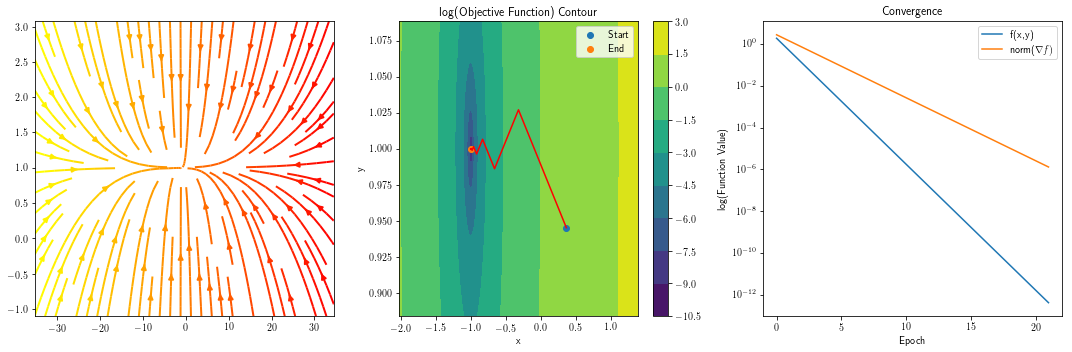

In [6]:
# Minimum finding / convex opt
f = lambda x: 1 * np.power(x[0] + 1, 2) + 3 * np.power(x[1] - 1, 2)
dfd0 = lambda x : centralDiffGrad(f, x)

opt = DescentOptimizer(step=.25)
theta, trace = opt.gradientDescent(np.random.rand(2), dfd0)

# Plot
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
streamPlot(fig, ax[0], trace, dfd0)
trajectoryPlot(fig, ax[1], trace, f)
convergencePlot(ax[2], trace, f, dfd0)
fig.tight_layout()
plt.show()

Model parameters:  [ 3.02881379  3.58732371]
Pearson R:  (0.99581714001969035, 1.1981188501897064e-30)


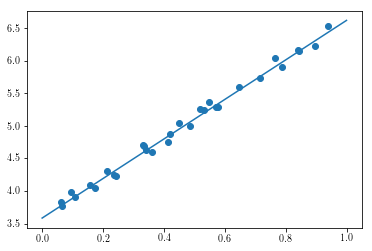

Start: f( [ 0.74680723  0.44024305] ) = 540.773153371
End: f( [ 3.02881379  3.58732371] ) = 0.163905074696


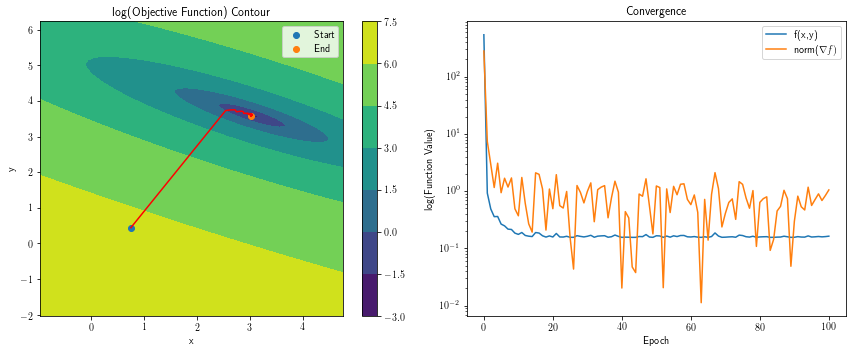

In [13]:
import scipy.stats

# Linear regression

# The ground truth
f = lambda x : 3 * x + 4

# The model
g = lambda theta, x : np.dot(theta, [x, 1])

# Observed data
XS = np.random.rand(30)
YS = [f(x) + 0.5* (0.5 * random.random() - 1) for x in XS]
XYS = zip(XS, YS)

# Cost Function (MLE)
J = lambda theta, xys : sum(np.power(np.dot(theta, np.array([x, 1])) - y, 2) for (x, y) in xys)
dJd0 = lambda theta, xys : centralDiffGrad(lambda thetap : J(thetap, xys), theta)

# Optimize
opt = DescentOptimizer(step = .05)
theta, trace = opt.stochasticGradientDescent(np.array(np.random.rand(2)), dJd0, XYS)
print "Model parameters: ", theta
print "Pearson R: ", scipy.stats.pearsonr(YS, map(lambda x: g(theta, x), XS))

#Plot
X = np.linspace(0, 1, 100)
Y = [g(theta, x) for x in X]
fig, ax = plt.subplots()
ax.plot(X, Y)
ax.scatter(XS, YS)
plt.show()

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
trajectoryPlot(fig, ax[0], trace, lambda x : J(x, XYS))
convergencePlot(ax[1], trace, lambda x : J(x, XYS), lambda x : dJd0(x, XYS))
fig.tight_layout()
plt.show()

Model parameters:  [ 2.49606351 -7.86331408]
Threshold:  3.15028606403
Accuracy:  0.945
Confusion Matrix 
[[94  6]
 [ 5 95]]


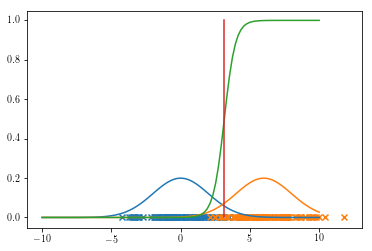

Start: f( [ 0.18475642  0.45662368] ) = 0.58414087063
End: f( [ 2.49606351 -7.86331408] ) = 0.131303557503


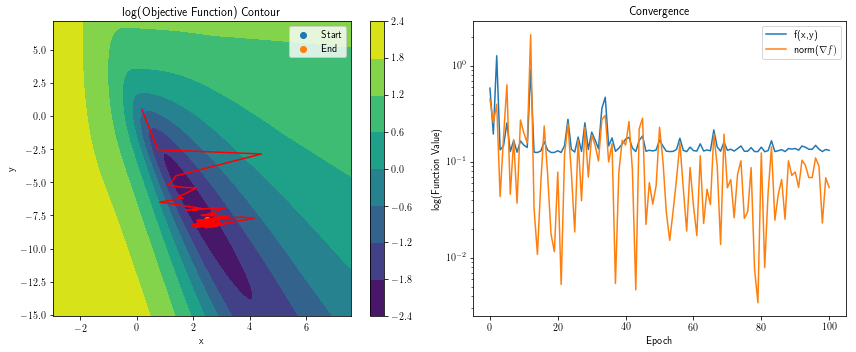

In [16]:
import scipy.stats
from sklearn.metrics import accuracy_score, confusion_matrix

# logistic regression
logistic = lambda x: 1.0 / (1.0 + np.exp(-x))
logisticModel = lambda w, x : logistic(np.dot(w, np.append(x, 1)))

# cross entropy
epsilon = 1e-6
boundedLog = lambda x : np.log(max(epsilon, min(1 - epsilon, x)))
H = lambda t, p : - t * boundedLog(p) - (1 - t) * boundedLog(1 - p)

# Loss function
L = lambda true, predicted : np.sum( H(t, p) for (t, p) in zip(true, predicted) ) / float(len(predicted))

# Cost function
J = lambda w, xys : L( map(lambda xy : xy[1], xys), map(lambda xy: logisticModel(w, xy[0]), xys) )
dJd0 = lambda w, xys : centralDiffGrad(lambda wp : J(wp, xys), w)

# Sample data
bias = 3
muA = bias + -3
muB = bias + +3
sigmaA = 2
sigmaB = 2

XSA = scipy.stats.norm.rvs(muA, sigmaA, 100)
YSA = np.repeat(0, 100)

XSB = scipy.stats.norm.rvs(muB, sigmaB, 100)
YSB = np.repeat(+1, 100)

XS = np.append(XSA, XSB)
YS = np.append(YSA, YSB)
XYS = zip(XS, YS)

# Solve
opt = DescentOptimizer(step=2)
theta, trace = opt.miniBatchGradientDescent(np.array(np.random.rand(2)), dJd0, XYS)
print "Model parameters: ", theta

x0 = -theta[1] / theta[0]
print "Threshold: ", x0

predicted = map(lambda x : 0 if x < x0 else + 1, XS)
print "Accuracy: ", accuracy_score(YS, predicted)
print "Confusion Matrix "
print confusion_matrix(YS, predicted)

support = np.linspace(-10, +10, 100)
zeros = np.zeros(100)

fig, ax = plt.subplots()
ax.plot(support, scipy.stats.norm.pdf(support, muA, sigmaA))
ax.scatter(XSA, zeros, marker='x')
ax.plot(support, scipy.stats.norm.pdf(support, muB, sigmaB))
ax.scatter(XSB, zeros, marker='x')
ax.plot(support, map(lambda x : logisticModel(theta, x), support))
ax.plot([x0, x0], [0, 1])
plt.show()

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
trajectoryPlot(fig, ax[0], trace, lambda x : J(x, XYS))
convergencePlot(ax[1], trace, lambda x : J(x, XYS), lambda x : dJd0(x, XYS))
fig.tight_layout()
plt.show()

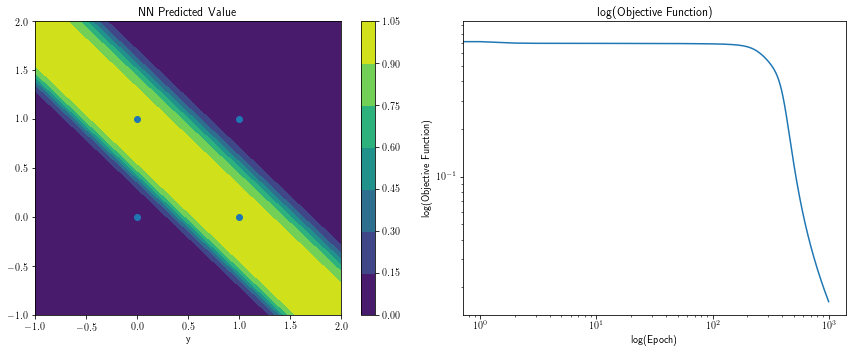

In [17]:
import copy

# Dense Feed Foward Neural Network

# Model
class Dense:
    def __init__(self, nodesThisLayer, nodesNextLayer):
        self.W = np.random.rand(nodesThisLayer * nodesNextLayer).reshape((nodesNextLayer, nodesThisLayer))
        self.b = np.random.rand(nodesNextLayer)
        self.activation = lambda x : 1.0 / (1.0 + np.exp(-x))
        
    def eval(self, x):        
        return self.activation(np.dot(self.W, x) + self.b)
    
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        
    def predict(self, x):
        y = x
        for layer in self.layers:
            y = layer.eval(y)
        return y
    
    def fit(self, XYS):
        learnRate = 1
        stepSize = 0.1
        sampleSize = int(0.2 * len(XYS))

        # cross entropy
        epsilon = 1e-6
        boundedLog = lambda x : np.log(max(epsilon, min(1 - epsilon, x)))
        H = lambda t, p : - t * boundedLog(p) - (1 - t) * boundedLog(1 - p)

        # Loss function
        L = lambda true, predicted : np.sum( H(t, p) for (t, p) in zip(true, predicted) ) / float(len(predicted))
        
        objValues = []
        for _ in xrange(0, 1000):
            sample = random.sample(XYS, sampleSize)
            XS = map(lambda x : x[0], XYS)
            YS = map(lambda x : x[1], XYS)
            # Objectiv function
            J = lambda : L(YS, map(lambda x : self.predict(x), XS))
            
            grad = copy.deepcopy(self)
            for slayer, glayer in zip(self.layers, grad.layers):
                glayer.W = centralDiffGrad(lambda w : J(), slayer.W, stepSize)
                glayer.b = centralDiffGrad(lambda w : J(), slayer.b, stepSize)

            for slayer, glayer in zip(self.layers, grad.layers):
                slayer.W = slayer.W - learnRate * glayer.W
                slayer.b = slayer.b - learnRate * glayer.b

            objValues.append(J())
            
        return objValues
                
model = NeuralNetwork()
model.layers.append(Dense(2, 3))
model.layers.append(Dense(3, 1))

# XOR
XS = [ np.array([0, 0]), np.array([0, 1]), np.array([1, 0]), np.array([1, 1]) ]
YS = [ 0, 1, 1, 0 ]
XYS = zip(XS, YS)

objFuncValues = model.fit(XYS)

X = np.linspace(-1, 2, 100)
Y = np.linspace(-1, 2, 100)
Z = generateScalarMesh(X, Y, model.predict)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

contourPlot(fig, ax[0], X, Y, Z)
ax[0].scatter(map(lambda x : x[0], XS), map(lambda x : x[1], XS))
ax[0].set_xlabel("x")
ax[0].set_xlabel("y")
ax[0].set_title("NN Predicted Value")

ax[1].plot(xrange(0, len(objFuncValues)), objFuncValues)
ax[1].set_xlabel("log(Epoch)")
ax[1].set_ylabel("log(Objective Function)")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_title("log(Objective Function)")

fig.tight_layout()
plt.show()